In [ ]:
!python --version


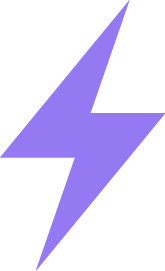

Connected to server at https://desolate-castle-4773.herokuapp.com


<IPython.core.display.Javascript object>

In [1]:
import logging, gensim, bz2
from gensim import corpora, models, similarities
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from bs4 import BeautifulSoup
import nltk
import re
from nltk.corpus import stopwords
import string
import itertools
import random
exclude = set(string.punctuation)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)
import numpy as np
from lightning import Lightning
from numpy import random, asarray
import networkx as nx
from __future__ import division
import math
import random
import pickle
lgn = Lightning(ipython=True, host='https://desolate-castle-4773.herokuapp.com/')
lgn.set_size(size='large')

In [2]:
topic_names = pickle.load( open( "topics_names.p", "rb" ) )

# Load text

In [3]:
def loadText(path):
    soup = BeautifulSoup( open(path), 'lxml')
    s = ' '
    for string in soup.find_all("source"):
        s += ' ' + string.string
    return s

In [4]:
text = loadText(u"all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_Übersetzten-en-tr-T.mxliff")

# tokenize

In [5]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
    
def tokenize(text):
    text = text.lower()
    # tokenize + punctuation
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+') # remove punctuation
    text = tokenizer.tokenize(text)
    # remove stopwords
    from nltk.corpus import stopwords
    stops = stopwords.words('english')
    text = [ w for w in text if w.lower() not in stops]
    # Exclude numbers
    text = [s for s in text if not re.search(r'\d',s)]
    #remove word with less than 3letters
    text = [s for s in text if len(s) > 2]
    # stemmer
    lmtzr = WordNetLemmatizer()
#     stemmer = SnowballStemmer("english")
    text =  [(lmtzr.lemmatize(t)) for t in text] 
    return text

In [6]:
tokens =  tokenize(text)

# load all texts

In [ ]:
import os
import sys
filelist = []
root = u"all_source_texts/"
for filename in os.listdir(root):
    filename = root + filename
    filelist .append(filename.encode(sys.getfilesystemencoding()))

i = 0
corpus_tokens = {}
for f in filelist:
    corpus_tokens[f] = tokenize(loadText( f ))
    i += 1


# Load LDA

In [ ]:
lda = gensim.models.ldamodel.LdaModel.load(u'lda/wikipedia_lda', mmap='r')

# make dictionary

In [ ]:
corpus = { f:lda.id2word.doc2bow(corpus_tokens[f]) for f in corpus_tokens}

# update lda 

In [ ]:
lda.update( corpus.values())

In [ ]:
# dictionary.save('dict_corpus')

In [ ]:
for f in filelist:
    topic = lda.get_document_topics(corpus[f])
    print(f + "  " + str(sum([ s[1] for s in topic])) )

# get topic distribution from a text

In [ ]:
def topicsFromFiles( path ):
    tokens = tokenize(loadText( path ))
    bow = lda.id2word.doc2bow( tokens )
    return lda.get_document_topics(bow)

In [ ]:
f = random.choice(filelist)
topicsFromFiles(f)

# store topics words

In [ ]:
# translate the lda topics in dictionnaries
i = 0
n = 100 # number of words per topics
topics = dict()
wordset = set()
for i in range(0,100):
    a = lda.print_topic(i, n)
    topic = dict()
#     print a
    pairs = a.split( ' + ')
    for p in pairs:
        pair = p.split('*')
#         print pair[0]
        value = float(pair[0])
        key = unicode(pair[1])
        topic[key] = value
        wordset.add(key)
    topics[i] = topic   
    i += 1

# show topic as a bag of words

In [ ]:
import PIL
from PIL import Image
from os import path
from wordcloud import WordCloud
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def WordCloudTopic( i ):
    # Generate a word cloud image
    wc = WordCloud(background_color="white", max_words=2000,
               max_font_size=40, random_state=42)
    wordcloud = wc.generate_from_frequencies(topics[i].items())    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def printCloud( frequencies, imagePath = "image.jpg" ):
    # Read the whole text.

    # Read the whole text.
#     text =" ".join(all_words) #open(path.join(d, 'alice.txt')).read()
#     print "text joined"

    # read the mask / color image
    # taken from http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
    alice_coloring = np.array(Image.open(imagePath))

    wc = WordCloud(background_color="white", max_words=200, mask=alice_coloring,
                   stopwords=STOPWORDS.add("said"),
                   max_font_size=300)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # create coloring from image
    image_colors = ImageColorGenerator(alice_coloring)

    # show
    # plt.imshow(wc)
    # plt.axis("off")
    # plt.figure()
    # recolor wordcloud and show
    # we could also give color_func=image_colors directly in the constructor
    plt.imshow(wc.recolor(color_func=image_colors))
    plt.axis("off")
    plt.figure()
    # plt.imshow(alice_coloring, cmap=plt.cm.gray)
    # plt.axis("off")
    plt.show()

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
WordCloudTopic(0)

# get the topic and the score for a unique word

In [ ]:
def getTopicFromWord( unique_word ):
    bow = lda.id2word.doc2bow( [unique_word] )
    topic = lda.get_document_topics(bow)
    if len(topic):
        return topic[0][0]
    else:
        return None


print getTopicFromWord('have')

In [ ]:
from scipy.sparse import *
from scipy import *
V = dok_matrix((0,100), dtype=float32)

def getTopic_n_topWordsWithinTopics( path ):
    tokens = tokenize(loadText( path ))
    bow = lda.id2word.doc2bow( tokens )
    topics =  lda.get_document_topics(bow)
    complex_topic = dict()
    complex_topic['topics'] = topics
    details = dict()
    max_details = 0
    for t in tokens:
        i = getTopicFromWord( t )
        if i != None:
            if i not in details.keys():
                details[i]  = dict()
            if t not in details[i].keys():
                details[i][t] = 1
            else:
                details[i][t] += 1
                if details[i][t] > max_details:
                    max_details = details[i][t]
                
    V = dok_matrix((1,100), dtype=float32)
    for t in topics:
        V[0,t[0]] = t[1]
    
    complex_topic['semantic_vector'] = V
    complex_topic['details'] = details
    complex_topic['max_details'] = max_details
    return complex_topic


In [ ]:
# complex_topics = dict()
# for f in filelist:
#     complex_topics[f] = getTopic_n_topWordsWithinTopics(f)
    
pickle.dump( complex_topics, open( "topics_from_files.p", "wb" ) )

complex_topics = pickle.load( open( "topics_from_files.p", "rb" ) )

In [ ]:
print loadText(f)

# display main topics and the top words from the text within a topic

In [ ]:
f = random.choice(filelist)
print f
x = complex_topics[f]
x_topics = x['topics']
x_details = x['details']
for i in sorted(x_topics, key=lambda tup: tup[1], reverse = True):
    print "score: %s " %i[1] + "| topic: %s" %topic_names[i[0]] + " | id topic: %s" %i[0]
    d = x_details[i[0]]
    for w in sorted(d, key=d.get, reverse=True)[:10]:
        print "-----  " + str(w) + ": " + str(d[w])

# similarity

In [ ]:
def norm(v):
    s = 0
#     it = v.itervalues()
#     while it:
#         s+= it
#         it.next()
    for d in v.itervalues():
        s+= d**2
    return sqrt(s)

def similarity( a, b):
    # cosine similarity
    p = (a.dot(b.transpose()) / (norm(a) * norm(b))).data
    if len(p):
        return p[0]


def closestFile( path ):
    x = getTopic_n_topWordsWithinTopics(path)
    u = x['semantic_vector']
    print type(u)
    similarities = dict()
    for s in complex_topics:
        v = complex_topics[s]['semantic_vector']
        similarities[s] = similarity(v,u)     
    k = 1
    for i in sorted(similarities.items(), key=lambda x: x[1])[::-1][:15]:
        print str(k) + "  |  "  + str(i)
        k += 1
        
    return similarities

In [ ]:
path = u"all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_Übersetzten-en-tr-T.mxliff"
closestFile( path )

In [ ]:
path = u"all_source_texts/1920-0002 Princess Interiors-en-fr_ca-CR.mxliff"
closestFile( path )

# display the results as a graph

In [ ]:
TRESHOLD = 2
min_score = 0.03 #5%

colours = []
colours.append( (26, 188, 156))
colours.append( (52, 152, 219))
colours.append( (155, 89, 182))
colours.append( (241, 196, 15))
colours.append( (231, 76, 60))
colours.append( (46, 204, 113))
colours.append( (230, 126, 34))
colours.append( (149, 165, 166))
colours.append( (52, 73, 94))

class idGenerator:
    def __init__(self):
        self.id = 0
    def get(self):
        self.id += 1
        return self.id - 1
    
    
class node:
    def __init__(self, index, label, weight = 30., color = (236, 240, 241)):
        self.index = index
        self.label = label
        self.childs = []
        self.weight = weight
        self.connections = None
        self.groups = []
        self.color = color
    def addChild( self, c ):
        self.childs.append( c )
        
    def getGraph(self):
        self.connections = []
        self.groups.append(0)
        graph = nx.Graph()
        graph.add_node( self.index, weight = self.weight, label = self.label, color = self.color)
        k = 0
        for c in self.childs: 
            color = colours[k]
            group = []
            k+=1
            if k >= len(colours):
                k = 0
            self.groups.append( k )
            graph.add_node( c.index, weight = c.weight, label = c.label, color = c.color)
            graph.add_edge(self.index, c.index )
            self.connections.append([ self.index, c.index, 0.1 ])
            for cc in c.childs:
                graph.add_node( cc.index, weight = cc.weight, label = cc.label, color = cc.color)
                graph.add_edge(c.index, cc.index )
                self.connections.append([ c.index, cc.index, 0. ])
                self.groups.append( 0 )
        return graph
    
    def getPos(self, sizeX = 5, sizeY = 15):
        X = []
        Y = []
        X.append(0)
        Y.append(  sizeY/2 )
        n = len(self.childs)
        cur = 0
        offset = 0.5
        for i in range(0, n):   
            c = self.childs[i]
            m = len(c.childs)
            w = c.weight
            X.append(3 * sizeX / 5)
            Y.append( cur  )
            offsetY = w * sizeY
            for j in range(0,m):
                # set word nodes position
                X.append( sizeX )# + 0.5* math.cos( 2 * 3.12 * j / m) )
                Y.append( cur + offset +  j/m * w * (sizeY - offset) - offsetY / 2)#+ 0.5 * math.sin( 2 * 3.12 * j / m))
            
            # set topics nodes postions
            cur += offsetY
            
        Y = [ sizeY - y for y in Y]      
        return X,Y
    
def makeGraphFromText( f ):
    id = idGenerator()
    x = complex_topics[f]
    x_topics = x['topics']
    x_details = x['details']
    max_details = x['max_details']
    text_node = node( id.get() , f)
    k = 1
    for i in sorted(x_topics, key=lambda tup: tup[1], reverse = True):
        if i[1] > min_score:
            color = colours[k]
            k+=1
            if k >= len(colours):
                k = 0
            topic_node = node( id.get(), topic_names[i[0]], weight = 50 * i[1], color = color )
            d = x_details[i[0]]
            # add words from text
            for w in sorted(d, key=d.get, reverse=True)[:10]:
                if d[w] > 1:
                    detail_node = node( id.get(), str(str(w) + ": " +  str(d[w])), weight =  18 * float(d[w]) / float(max_details))
                    topic_node.addChild(detail_node)
            # add words from topics
            for w in sorted(topics[i[0]], key=topics[i[0]].get, reverse=True)[:20]: 
                detail_node = node( id.get(), str(str(w) + ": " +  str(topics[i[0]][w])), weight =  300 * float(topics[i[0]][w]), color = color )
                topic_node.addChild(detail_node)

            text_node.addChild( topic_node )
            
    return text_node

In [ ]:
# https://desolate-castle-4773.herokuapp.com/sessions/

f = random.choice(filelist)
G = makeGraphFromText( f )

print f
graph = G.getGraph()
connections = G.connections
groups = G.groups
X,Y = G.getPos(2 , 30)
mat = asarray(nx.adjacency_matrix(graph).todense())
weights =  nx.get_node_attributes(graph, 'weight').values()
labels = nx.get_node_attributes(graph, 'label').values()
colors = nx.get_node_attributes(graph, 'color').values()
colors = np.vstack(colors)

lgn.force(mat, size = weights, labels = labels, color = colors)

# topic distribution along a text

In [ ]:
def split_seq(seq, num_pieces):
    start = 0
    for i in xrange(num_pieces):
        stop = start + len(seq[i::num_pieces])
        yield seq[start:stop]
        start = stop
        
def getTopicsDistributionWithinTheText(path, words = 300 ):
    text = loadText(path)
    tokens = tokenize(text)
    steps = int(len(tokens) / words)
    if steps < 2:
        steps = 2
    bow = lda.id2word.doc2bow(tokens)
    global_scores = lda.get_document_topics(bow)
    scores = dict()
    for i in sorted(global_scores, key=lambda tup: tup[1], reverse = True):
        if i[1] > min_score:
            scores[i[0]] = []
    chunks = split_seq(tokens, steps)
    i = 1
    for c in chunks:
        bow = lda.id2word.doc2bow(c)
        score = lda.get_document_topics(bow)
        for s in score:
            if s[0] in scores.keys():
                scores[s[0]].append(s[1])
                
        for s in scores:
            if len(scores[s]) < i:
                scores[s].append(0)
        i += 1
        
    return scores, global_scores
    

In [ ]:
import numpy as np
from scipy import interpolate
from scipy.interpolate import interp1d

print f

def displayTopicsDistributionWithinTheText(f, chunk_length = 300):

    distribAlongText, global_scores = getTopicsDistributionWithinTheText(f, chunk_length)

    global_scores =  sorted(global_scores, key=lambda tup: tup[1], reverse = True)
    scores = []
    for g in global_scores:
        if g[0] in distribAlongText.keys():
            scores.append( distribAlongText[g[0]])
    k = 1
    
    # draw pie chart
    values = []
    labels = []
    for s in global_scores:
        if s[1] > min_score:
            values.append(s[1])
            labels.append(topic_names[s[0]])
    matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)  
    plt.pie(values,  labels=labels, colors = [ [1.0 / 255.0 * c for c in cc] for cc in colours[1:]])
    plt.show()
    matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
    # print type(scores)
    x = range( 0, len(scores[0]))
    x = [ chunk_length * i for i in x]
    for s in scores:
#         xnew = np.arange(min(x), max(x))
#         ynew = interpolate.splev(xnew,tck,der=0)
#         fun = interp1d(x, s, kind='cubic')
    #     plt.plot(xnew, fun(xnew),linewidth = 5, color = [ 1.0 / 255.0 * c for c in colours[k]], alpha = 0.6)
    #     plt.plot(xnew, ynew,linewidth = 5, color = [ 1.0 / 255.0 * c for c in colours[k]], alpha = 0.6)
        plt.plot(x, s,linewidth = 5, color = [ 1.0 / 255.0 * c for c in colours[k]], alpha = 0.6)
        plt.fill_between(x, s,linewidth = 5, color = [ 1.0 / 255.0 * c for c in colours[k]], alpha = 0.3)
        k += 1
        if k >= len(colours):
            k = 0

    plt.ylabel('proportion')
    plt.xlabel('number of words')
    plt.show()
    
displayTopicsDistributionWithinTheText(f, 300)

# Complex words

In [ ]:
def getlongwords( path ):
    text = loadText(path)
    tokens = tokenize(text)
    f = nltk.FreqDist(tokens)
    result = dict()
    tokens = sorted(set(tokens), key=lambda w: len(w), reverse = True)
    for w in sorted(set(tokens), key=lambda w: len(w), reverse = True)[:15] :
        print w + ": " +  str(f[w])
        
    return tokens
 
# path = u"all_source_texts/1920-0002 Princess Interiors-en-fr_ca-CR.mxliff"
path = u"all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_Übersetzten-en-tr-T.mxliff"

r = getlongwords( path )

# construct a corpus to compute frequencies

In [ ]:
import nltk
from nltk.corpus import reuters
# print  "corpus with: %s words (%s distincts) " %(len(reuters.words()), len(set(reuters.words())))

# freq_english = nltk.FreqDist(reuters.words())

In [ ]:
freq_english["satisfaction"]

In [ ]:
def getMostSignificativeWords( path ):
    text = loadText(path)
    tokens = tokenize(text)
    f = nltk.FreqDist(tokens)
    word_set = set(tokens)
    result = dict()
    for w in word_set:
        score = len(w)  / np.log(2 +  freq_english[w])
        result[w] = score
    return result

def CloudFromSignificantWords( path, img_path ):
    words = getMostSignificativeWords(path)
    items = []
    for w in sorted(words, key=words.get, reverse=True)[:100]:
        items.append( (w, words[w]))
    printCloud( items, img_path )

In [ ]:
# mostSignificative = getMostSignificativeWords(path)
# for w in sorted(mostSignificative, key=mostSignificative.get, reverse=True)[:10]:
#     print  str(w) + ": " + str(mostSignificative[w])

CloudFromSignificantWords(path, "image.jpg")

# text complexity

In [ ]:
# https://pypi.python.org/pypi/textstat/

from textstat.textstat import textstat

difficulties = dict()
for f in filelist:
    txt = unicode(loadText(f))
    try:
        difficulties[f] = textstat.automated_readability_index((txt))
    except:
        print "fail:" + str(f)
        
print textstat.automated_readability_index((f))
print loadText(f)

In [ ]:
plt.fill_between(range(0,len(difficulties)),sorted(difficulties.values(), reverse = True), color = [ 1.0 / 255.0 * c for c in colours[0]], alpha = 0.6)

# Test all on a text

In [ ]:
path = u"all_source_texts/babyshop texter vecka 33-en-fi-T.mxliff"
# path = u"all_source_texts/Re-Nutriv Script_Final Translation Template_deadline 20. april-en-da-T.mxliff"
path = random.choice(filelist)
print loadText(path)

In [ ]:
print "mingningful words"
CloudFromSignificantWords(path, "image_gradient.jpg")
print "topic distribution"
displayTopicsDistributionWithinTheText(path, 300)

In [ ]:
# path = u"all_source_texts/babyshop texter vecka 33-en-fi-T.mxliff"
# path = u"all_source_texts/Re-Nutriv Script_Final Translation Template_deadline 20. april-en-da-T.mxliff"
G = makeGraphFromText( path )

print "topic graph"
print path
graph = G.getGraph()
connections = G.connections
groups = G.groups
X,Y = G.getPos(2 , 30)
mat = asarray(nx.adjacency_matrix(graph).todense())
weights =  nx.get_node_attributes(graph, 'weight').values()
labels = nx.get_node_attributes(graph, 'label').values()
colors = nx.get_node_attributes(graph, 'color').values()
colors = np.vstack(colors)

lgn.force(mat, size = weights, labels = labels, color = colors)





In [ ]:
# mostSignificative = getMostSignificativeWords(path)
# for w in sorted(mostSignificative, key=mostSignificative.get, reverse=True)[:30]:
#     print  str(w) + ": " + str(mostSignificative[w])
    
# drawNX(graph)

# trash

In [ ]:
# draw graph with networkX


def drawNX(graph):
    i = 0
    matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)
    labelsNX = dict()
    for l in labels:
        labelsNX[i] = l
        i += 1

    i = 0
    weightsNX = dict()
    for l in weights:
        weightsNX[i] = l
        i += 1

    pos=nx.spring_layout(graph)
    nx.draw(graph, labels = labelsNX,pos = pos, edge_color = 'gray', node_color  = [ [(1.0/255.0) * cc for cc in c]  for c in colors], node_size  = [ 80 * w for w in weights], alpha = 0.7, font_size = 18)
    plt.show()

In [ ]:
# graph bundle
# from numpy import random, ceil, array
# import numpy as np
# x = random.randn(10)
# y = random.randn(10)
# mat = random.rand(10,10)
# mat[mat>0.75] = 0

# mat = np.zeros((len(connections), 3))
# # lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')
# # lgn.set_size(size='large')
# print len(x)
# print len(connections)
# for i in range( 0, len(connections)):
#     mat[i,0] = connections[i][0]
#     mat[i,1] = connections[i][1]
#     mat[i,2] = connections[i][2]
    
# mat2 = np.ones((len(X), len(Y)) )
# # print mat2
# # print X
# # print Y

# lgn.graphbundled(X,Y,  mat, size = weights, labels = labels, color = colours)




In [ ]:
freqs = nltk.FreqDist(nltk.corpus.gutenberg.words())
    
printCloud( freqs.most_common(500), "image.jpg")

In [ ]:
sorted(topics[94].items(), key=lambda x: x[1],reverse = True)

In [ ]:
topic_names = dict()
for i in range(0,100):
    topic_names[i] = i
    
topic_names[0] = "space - sci fi"
topic_names[1] = "american football"
topic_names[2] = "design"
topic_names[3] = "japan"
topic_names[4] = "american eduacation"
topic_names[5] = "north carolina"
topic_names[6] = "cities - airports ?"

topic_names[72] = 'IT'
topic_names[78] = 'positive words - marketing'
topic_names[2] = 'design - production'
topic_names[89] = 'nutrition'
topic_names[41] = 'military - emergency'
topic_names[64] = 'colors - nature'
topic_names[83] = 'food'
topic_names[55] = 'clothes - materials'
topic_names[77] = 'TV - people - fashion'
topic_names[29] = 'music'
topic_names[81] = 'human ressources'
topic_names[97] = 'science'
topic_names[40] = 'health'
topic_names[73] = 'mountains - nature'
topic_names[16] = 'buildings'
topic_names[25] = 'business - distribution'
topic_names[67] = 'medieval'
topic_names[86] = 'childish - games'
topic_names[94] = 'classical music - composers'

pickle.dump( topic_names, open( "topics_names.p", "wb" ) )

In [ ]:
topics_distrib = dict()

for t in complex_topics:
    for s in complex_topics[t]['topics']:
        if s[0] in topics_distrib.keys():
            topics_distrib[s[0]] += s[1]
        else:
            topics_distrib[s[0]] = s[1]
            
for w in sorted(topics_distrib, key=topics_distrib.get, reverse=True)[:20]:
    print str(w) + ": " + str(topics_distrib[w])
        

In [ ]:
%%html
<iframe src="https://desolate-castle-4773.herokuapp.com/visualizations/88577a1f-8dcf-4891-9bfe-a6c00d7aa2f4/iframe/” width="1200" height="500" >

## compare source and target with sentiment

In [20]:
from translate import translator

In [21]:
translator('en', 'fr', 'Hello World!')

HTTPError: 503 Server Error: Service Unavailable for url: https://translate.google.com/translate_a/single?oe=utf-8&q=Hello+World%21&tl=fr&client=a&sl=en&dt=t&ie=utf-8

In [56]:
f = open('sentiment.txt', 'r').read().split("\n")[4:]

In [57]:
sentiment={}
i=0
while i < len(f)-1:
    sentiment[f[i].split()[0]]=f[i].split()[1]
    i+=1

In [46]:
def loadTextTarget(path):
    soup = BeautifulSoup( open(path), 'lxml')
    s = ' '
    for string in soup.find_all("Target"):
        s += ' ' + string.string
    return s

In [53]:
text = loadText(u"all_source_texts/_WL-Contact_Technical_And_Functional_Proposal-1-en-de-T.mxliff")

In [52]:
target = loadTextTarget(u"all_source_texts/_WL-Contact_Technical_And_Functional_Proposal-1-en-de-T.mxliff")

In [62]:
translate=[]
for key in sentiment:
    translate.append(translator('en', 'de', key)[0][0][0])

HTTPError: 503 Server Error: Service Unavailable for url: https://translate.google.com/translate_a/single?oe=utf-8&q=raining&tl=de&client=a&sl=en&dt=t&ie=utf-8